### Preliminary data analysis for CS591 Project on secondary shoe market StockX.com
###### by David Neary and Anton Njavro

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import gc
from datetime import datetime
import seaborn as sns
import matplotlib.animation as animation
from matplotlib import rc
from datetime import datetime
import datetime
import time

In [2]:
#Load our data
stockx_2019_data = pd.read_csv('data/2019_data_stockx.csv')

In [3]:
#def days()
def days(given_date_difference):
    return abs(given_date_difference.days)

In [4]:
#Edit dates to datetime format YYY/MM/DD
stockx_2019_data['Order Date'] = pd.to_datetime(stockx_2019_data['Order Date'])
stockx_2019_data['Release Date'] = pd.to_datetime(stockx_2019_data['Release Date'])
#Add column containing day difference between Release Date and Order Date
stockx_2019_data['Date Difference'] = (stockx_2019_data['Release Date'] - stockx_2019_data['Order Date']).apply(days)

In [5]:
stockx_2019_data.head(5)

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Date Difference
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,"$1,097",$220,2016-09-24,11.0,California,342
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,$685,$220,2016-11-23,11.0,California,282
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,$690,$220,2016-11-23,11.0,California,282
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,"$1,075",$220,2016-11-23,11.5,Kentucky,282
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,$828,$220,2017-02-11,11.0,Rhode Island,202


In [6]:
stockx_2019_data.shape

(99956, 9)

In [7]:
#Turn Sale Price column and Retail Price into int
def toPrice(given_price):
    #From $xxx to int(xxx) format
    return int(given_price[1:].replace(',', ''))

In [8]:
#Transform price columns in proper format 
stockx_2019_data['Sale Price'] = stockx_2019_data['Sale Price'].apply(toPrice)
stockx_2019_data['Retail Price'] = stockx_2019_data['Retail Price'].apply(toPrice)

In [9]:
stockx_2019_data.head(5)

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Date Difference
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097,220,2016-09-24,11.0,California,342
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685,220,2016-11-23,11.0,California,282
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690,220,2016-11-23,11.0,California,282
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075,220,2016-11-23,11.5,Kentucky,282
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828,220,2017-02-11,11.0,Rhode Island,202


In [10]:
#Let's see some information about sale prices
stockx_2019_data['Sale Price'].describe()

count    99956.000000
mean       446.634719
std        255.982969
min        186.000000
25%        275.000000
50%        370.000000
75%        540.000000
max       4050.000000
Name: Sale Price, dtype: float64

In [46]:
stockx_2019_data['Retail Price'].describe()

count    99956.00000
mean       208.61359
std         25.20001
min        130.00000
25%        220.00000
50%        220.00000
75%        220.00000
max        250.00000
Name: Retail Price, dtype: float64

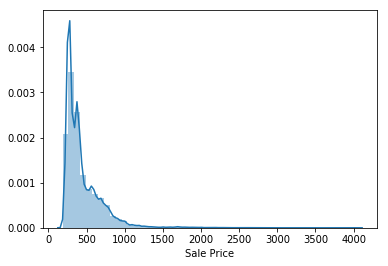

In [44]:
#Plot price column, as we can see most of the prices hoover around $200-$500
sns.distplot(stockx_2019_data['Sale Price'])

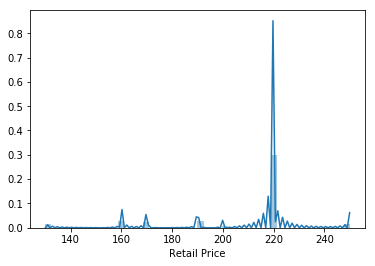

In [45]:
#Retail prices are very much centered around $200 dollars
sns.distplot(stockx_2019_data['Retail Price'])

In [11]:
#Let's see some information about retail prices
stockx_2019_data['Retail Price'].describe()

count    99956.00000
mean       208.61359
std         25.20001
min        130.00000
25%        220.00000
50%        220.00000
75%        220.00000
max        250.00000
Name: Retail Price, dtype: float64

As we can see there is a significant difference in means with sale price being more than double of the retail price on average.

In [12]:
#List of Brands
brands = stockx_2019_data.Brand.unique()
#List of dates
dates = stockx_2019_data['Order Date'].unique()
#List of sneaker names
sneaker_names = stockx_2019_data['Sneaker Name'].unique()
#Shoe sizes
shoe_sizes = sorted(stockx_2019_data['Shoe Size'].unique())
#Buyer State
buyer_state = stockx_2019_data['Buyer Region'].unique()
#Release dates
release_dates = stockx_2019_data['Release Date'].unique()
#Date difference
date_difference = sorted(stockx_2019_data['Date Difference'].unique())

our_lists = [brands,dates,sneaker_names,shoe_sizes,buyer_state,release_dates] 

In [13]:
#Calculate percentages
#Percentage between Yeezy/Off-White
brand_percentage = stockx_2019_data['Brand'].value_counts(normalize=True) * 100
#Gives top 25 states, 92.8% of all sales
state_percentage = stockx_2019_data['Buyer Region'].value_counts(normalize=True)[:25] * 100
#Shoe Size percentages
shoe_size_percentage = stockx_2019_data['Shoe Size'].value_counts(normalize=True) * 100
#Shoe models percentages (top 25 of shoe_models are 91% of sales)
shoe_models_percentage = stockx_2019_data['Sneaker Name'].value_counts(normalize=True) * 100
#Dates percentages (Top 2 dates are related to Yeezy releases)
dates_percentage = stockx_2019_data['Order Date'].value_counts(normalize=True) * 100
#Date Difference percentages (Info, 10% of all sales happen within 2 days of release, 22% of all sales happen within 9 dates)
date_difference_percentage = stockx_2019_data['Date Difference'].value_counts(normalize=True) * 100

In [14]:
#Function to plot Pie-charts
def pie_chart(labels,sizes):
    #explode = (0, 0.1, 0, 0)
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)# Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')  
    plt.tight_layout()
    plt.show()

#Extract labels from percentages
def extract_label_list(given_np_list):
    #Return 2 lists, 1st: [labels], 2nd: [percentages]
    #given_np_list
    label_list = []
    pct_list = []
    for i in range(len(given_np_list)):
        #print(given_np_list[i])
        label_list.append(given_np_list[given_np_list==given_np_list[i]].index[0])
        pct_list.append(given_np_list[i])
    #print(label_list)
    return label_list, pct_list
        

[' Yeezy', 'Off-White']


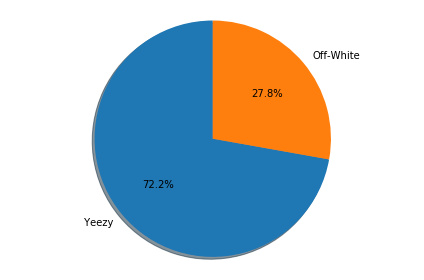

In [15]:
#Brands Pie-Chart
brand_label,brand_pct = extract_label_list(brand_percentage)
pie_chart(brand_label,brand_pct)

['California', 'New York', 'Oregon', 'Florida', 'Texas', 'New Jersey', 'Illinois', 'Pennsylvania', 'Massachusetts', 'Michigan']


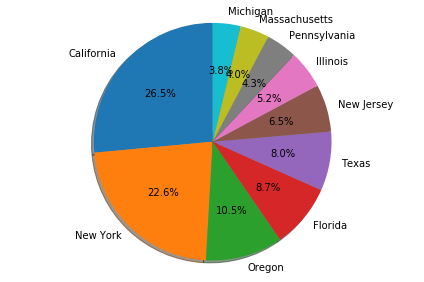

In [16]:
#State Percentages (Only for top 10 states)
state_label, state_pct = extract_label_list(state_percentage[:10])
pie_chart(state_label,state_pct)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


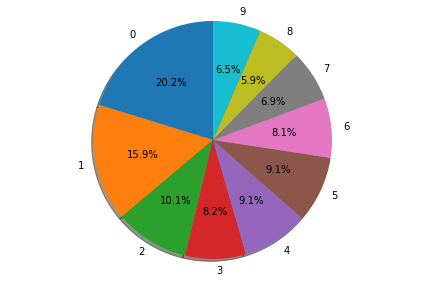

In [17]:
#Percentage of sales within release date (Only for top 10 differences)
date_difference_label, date_difference_pct = extract_label_list(date_difference_percentage[:10])
pie_chart(date_difference_label,date_difference_pct)

In [27]:
#Try plotting histogram with x-axis days, y-axis number of sales
date_difference_label

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

#### Google Trends data

Data from Google trends will be downloaded for dates: 06/01/2015 to 03/01/2019


In [28]:
#Google trends for term "Adidas Yeezy"
adidas_yeezy_gtrends = pd.read_csv('data/adidas_yeezy_gtrends.csv')
#Transform Week column in needed format
adidas_yeezy_gtrends['Week'] = adidas_yeezy_gtrends['Week'].apply(pd.Timestamp)
adidas_yeezy_gtrends.rename(columns = {'Adidas Yeezy: (United States)':'Adidas Yeezy'}, inplace = True) 

#Google trends for term "Off White"
off_white_gtrends = pd.read_csv('data/off_white_gtrends.csv')
#Transform Week column in needed format
off_white_gtrends['Week'] = off_white_gtrends['Week'].apply(pd.Timestamp)
off_white_gtrends.rename(columns = {'Off-White: (United States)':'Off-White'}, inplace = True) 

#Google trends for term "Kanye West"
kanye_west_gtrends = pd.read_csv('data/kanye_west_gtrends.csv')
#Transform Week column in needed format
kanye_west_gtrends['Week'] = kanye_west_gtrends['Week'].apply(pd.Timestamp)
kanye_west_gtrends.rename(columns = {'Kanye West: (United States)':'Kanye West'}, inplace = True) 

In [29]:
off_white_gtrends.head()

,Week,Off-White
0,2015-06-07,5
1,2015-06-14,6
2,2015-06-21,5
3,2015-06-28,6
4,2015-07-05,7


#### Let's see some information about Google Trends data

In [30]:
adidas_yeezy_gtrends.describe()

,Adidas Yeezy
count,200.000000
mean,26.220000
std,11.968199
min,3.000000
25%,19.750000
50%,24.000000
75%,30.000000
max,100.000000


In [31]:
off_white_gtrends.describe()

,Off-White
count,200.000000
mean,34.555000
std,26.473975
min,5.000000
25%,10.000000
50%,20.000000
75%,59.250000
max,100.000000


In [32]:
kanye_west_gtrends.describe()

,Kanye West
count,200.000000
mean,10.250000
std,10.578612
min,4.000000
25%,5.000000
50%,7.000000
75%,11.000000
max,100.000000


##### To have a more meaningful analysis we will only focus on peaks in Google trends, peaks we will define as everything that's 1STD above mean.

In [33]:
kanye_west_peaks = kanye_west_gtrends[kanye_west_gtrends['Kanye West'] >= (kanye_west_gtrends.describe().iloc[1][0] + kanye_west_gtrends.describe().iloc[2][0])]
off_white_peaks = off_white_gtrends[off_white_gtrends['Off-White'] >= (off_white_gtrends.describe().iloc[1][0] + off_white_gtrends.describe().iloc[2][0])]
adidas_yeezy_peaks = adidas_yeezy_gtrends[adidas_yeezy_gtrends['Adidas Yeezy'] >= (adidas_yeezy_gtrends.describe().iloc[1][0] + adidas_yeezy_gtrends.describe().iloc[2][0])]

In [35]:
off_white_peaks.head()

,Week,Off-White
126,2017-11-05,68
128,2017-11-19,100
129,2017-11-26,65
133,2017-12-24,67
135,2018-01-07,67


##### We will then try to calculate date difference between StockX resale date and related peak date 
###### Calculate distance from closest peak date

In [37]:
#This part loads for long
#Let's add columns for Google Trends peaks differences
def kanye_peak_distance(given_date):
    #Taken a given_date try to find closest kanye_gtrends_peak and return its distance
    #min_dist = abs(given_date - kanye_west_peaks['Week'].iloc[0])
    min_d = 10000000
    for i,j in kanye_west_peaks.iterrows():
        #Difference between all Kanye peaks and 2017-09-01
        date_diff = (given_date-j['Week']).days
        #print(date_diff)
        if date_diff < min_d and date_diff >=0:
            min_d = date_diff  
    if min_d == 10000000:
        #print(None)
        return None
    return min_d

def offwhite_peak_distance(given_date):
    #Taken a given_date try to find closest kanye_gtrends_peak and return its distance
    #min_dist = abs(given_date - kanye_west_peaks['Week'].iloc[0])
    min_d = 10000000
    for i,j in off_white_peaks.iterrows():
        #Difference between all Kanye peaks and 2017-09-01
        date_diff = (given_date-j['Week']).days
        #print(date_diff)
        if date_diff < min_d and date_diff >=0:
            min_d = date_diff  
    if min_d == 10000000:
        #print(None)
        return None
    return min_d


def yeezy_peak_distance(given_date):
    #Taken a given_date try to find closest kanye_gtrends_peak and return its distance
    #min_dist = abs(given_date - kanye_west_peaks['Week'].iloc[0])
    min_d = 10000000
    for i,j in adidas_yeezy_peaks.iterrows():
        #Difference between all Kanye peaks and 2017-09-01
        date_diff = (given_date-j['Week']).days
        #print(date_diff)
        if date_diff < min_d and date_diff >=0:
            min_d = date_diff  
    if min_d == 10000000:
        #print(None)
        return None
    return min_d



stockx_2019_data['Kanye Trend Diff'] = stockx_2019_data['Order Date'].apply(kanye_peak_distance)
stockx_2019_data['Off-White Trend Diff'] = stockx_2019_data['Order Date'].apply(offwhite_peak_distance) 
stockx_2019_data['Yeezy Trend Diff'] = stockx_2019_data['Order Date'].apply(yeezy_peak_distance) 

In [47]:
stockx_2019_data.head(5)

,Order Date,Brand,Sneaker Name,Sale Price,Retail Price,Release Date,Shoe Size,Buyer Region,Date Difference,Kanye Trend Diff,Off-White Trend Diff,Yeezy Trend Diff
0,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-Low-V2-Beluga,1097,220,2016-09-24,11.0,California,342,285,NaN,75
1,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Copper,685,220,2016-11-23,11.0,California,282,285,NaN,75
2,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Green,690,220,2016-11-23,11.0,California,282,285,NaN,75
3,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red,1075,220,2016-11-23,11.5,Kentucky,282,285,NaN,75
4,2017-09-01,Yeezy,Adidas-Yeezy-Boost-350-V2-Core-Black-Red-2017,828,220,2017-02-11,11.0,Rhode Island,202,285,NaN,75


### Data visualizations

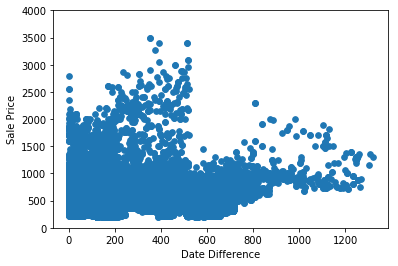

In [81]:
#For this example we randomly sampled only half of data in order to have better visualization (not too crowded, however same trend of sudden decrease is noticable)
sample_for_visualization = stockx_2019_data.sample(frac=0.8, replace=True, random_state=1)
var = 'Date Difference'
data = pd.concat([sample_for_visualization['Sale Price'], sample_for_visualization[var]], axis=1)
data.plot.scatter(x=var, y='Sale Price', ylim=(0,4000), s=32);

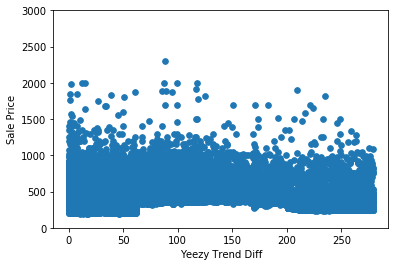

In [80]:
#Isolate yeezy shoes only, and plot 'Yeezy Trend Diff' vs Price
yeezy_subset = stockx_2019_data[stockx_2019_data['Brand']==' Yeezy']
var = 'Yeezy Trend Diff'
data = pd.concat([yeezy_subset['Sale Price'], yeezy_subset[var]], axis=1)
data.plot.scatter(x=var, y='Sale Price', ylim=(0,3000), s=32);

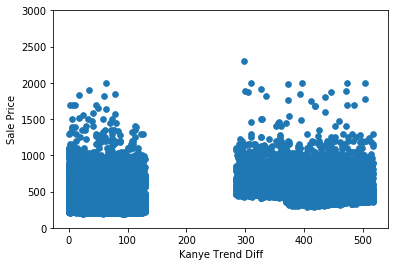

In [83]:
var = 'Kanye Trend Diff'
data = pd.concat([yeezy_subset['Sale Price'], yeezy_subset[var]], axis=1)
data.plot.scatter(x=var, y='Sale Price', ylim=(0,3000), s=32);

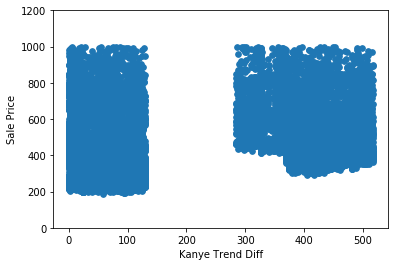

In [89]:
#Remove extremes from Kanye subset, all retail prices above $1000
no_extreme_yeezy = yeezy_subset[yeezy_subset['Sale Price']<1000]
var = 'Kanye Trend Diff'
data = pd.concat([no_extreme_yeezy['Sale Price'], no_extreme_yeezy[var]], axis=1)
data.plot.scatter(x=var, y='Sale Price', ylim=(0,1200), s=32);

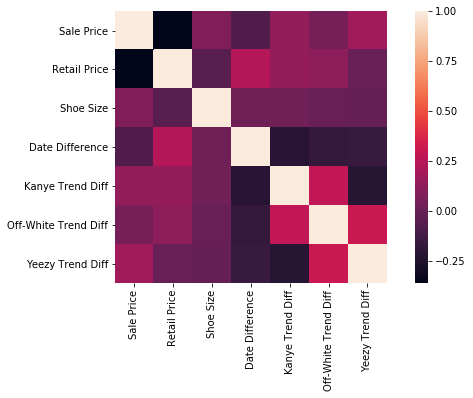

In [102]:
#StockX data correlation
corrmat = stockx_2019_data.corr()
f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(corrmat, vmax=1, square=True);

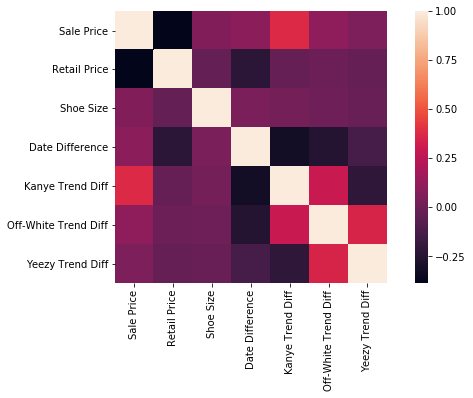

In [104]:
#Yeezy correlation
corrmat = stockx_2019_data[stockx_2019_data['Brand'] == ' Yeezy'].corr()
f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(corrmat, vmax=1, square=True);

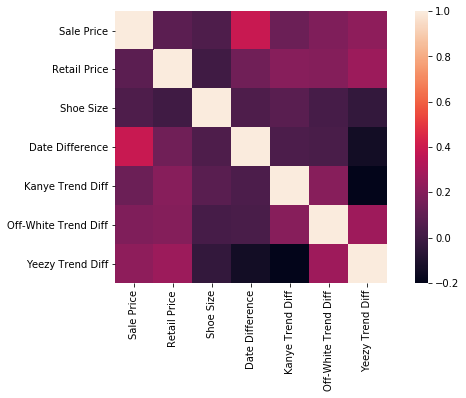

In [107]:
corrmat = stockx_2019_data[stockx_2019_data['Brand'] == 'Off-White'].corr()
f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(corrmat, vmax=1, square=True);

/Users/antonnjavro/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


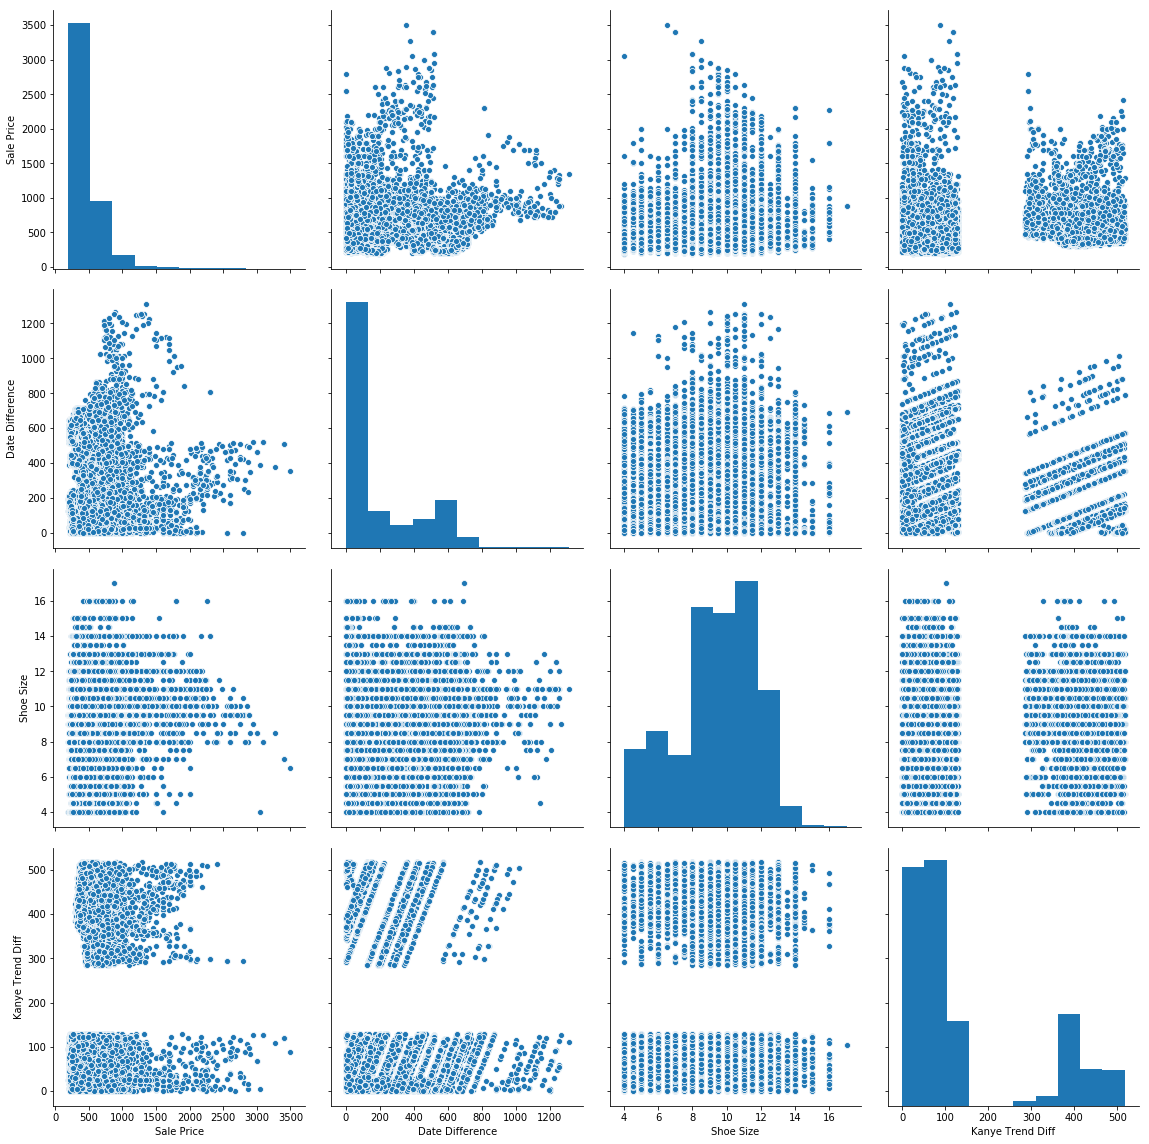

In [98]:
cols = ['Sale Price', 'Date Difference', 'Shoe Size', 'Kanye Trend Diff']
sns.pairplot(stockx_2019_data.sample(frac=0.5, replace=True, random_state=1)[cols], size = 4);